# Loading dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# scaling/preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression #model_1
from sklearn.neighbors import KNeighborsClassifier #model_2
from sklearn.tree import DecisionTreeClassifier, plot_tree #model_3
from xgboost import XGBClassifier #model_4
from lightgbm import LGBMClassifier #model_5
from sklearn.ensemble import RandomForestClassifier # model_6

# metrics
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, recall_score
macro_recall_scorer = make_scorer(recall_score, average='macro')

from warnings import simplefilter
simplefilter("ignore")

## Importing the Data

In [ ]:
df = pd.read_csv('training.csv')
df.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          0                                           0.512114          
1          0                                           0.492224          
2          0                                           0.527812          
3          0                                           0.565690          
4          0                                           0.516112          

    ROA(A) before interest and % after tax  \
0                                 0.592237   
1                                 0.562582   
2                                 0.585805   
3                                 0.639610   
4                                 0.586077   

    ROA(B) before interest and depreciation after tax  \
0                                           0.559612    
1                                           0.551100    
2                                           0.576958    
3                                           0.624819    
4                                           0.568392    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.613175                      0.613175   
1                 0.600311                      0.600333   
2                 0.605457                      0.605363   
3                 0.602769                      0.602769   
4                 0.605543                      0.605551   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.999062                    0.797565   
1                0.998979                    0.797417   
2                0.999076                    0.797615   
3                0.999053                    0.797495   
4                0.999075                    0.797713   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.809463                                      0.303636   
1                      0.809353                                      0.303551   
2                      0.809512                                      0.303694   
3                      0.809416                                      0.303535   
4                      0.809605                                      0.303867   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.826537                    0.011653   
1  ...                     0.811231                    0.007018   
2  ...                     0.823664                    0.003584   
3  ...                     0.842413                    0.005825   
4  ...                     0.817378                    0.005758   

    No-credit Interval   Gross Profit to Sales  \
0             0.623926                0.613173   
1             0.623684                0.600313   
2             0.628218                0.605454   
3             0.624091                0.602766   
4             0.624746                0.605544   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.842158              0.278042   
1                             0.841243              0.279404   
2                             0.841501              0.275661   
3                             0.843951              0.280197   
4                             0.841366              0.276985   

    Degree of Financial Leverage (DFL)  \
0                             0.026838   
1                             0.026974   
2                             0.026856   
3                             0.026814   
4                             0.026867   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.565373                   1   
1                                           0.565902                   1   
2                                           0.565451                   1   
3                                           0.565266                   1   
4                        

## Capping outliers

In [ ]:
def outlier_imputer(data,features):
    data_out = data.copy()
    for column in features:
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        IQR = Q3 - Q1
        lowerL = (Q1 - 1.5 * IQR)
        higherL = (Q3 + 1.5 * IQR)

        data_out.loc[data_out[column] < lowerL,column] = lowerL
        data_out.loc[data_out[column] > higherL,column] = higherL

    return data_out

data_in    = df.select_dtypes(include='float')
features_in = data_in.columns

capped_data = outlier_imputer(data_in,features_in)
data_int = df.select_dtypes(include='int')

df2 = pd.concat([capped_data,data_int],axis=1)

X = df2.drop(columns='Bankrupt?')
y = df2['Bankrupt?']

generating the comparitive boxplots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comparative_boxplots(original_data, capped_data, features):
    plt.figure(figsize=(15, len(features) * 4))

    for i, column in enumerate(features, 1):
        plt.subplot(len(features), 2, 2*i-1)
        sns.boxplot(y=original_data[column], color='lightblue')
        plt.title(f'Original Data - {column}')

        plt.subplot(len(features), 2, 2*i)
        sns.boxplot(y=capped_data[column], color='lightgreen')
        plt.title(f'Capped Data - {column}')

    plt.tight_layout()
    plt.show()

# Call the function with original and capped data
plot_comparative_boxplots(data_in, capped_data, features_in)

In [ ]:
val = df['Bankrupt?'].value_counts().reset_index(name='count')

val

Bankrupt?  count
0          0   5301
1          1    154

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

## SMOTE with custom class ratios

In [ ]:
def resampled(X_train,y_train,r):
  smote = SMOTE(sampling_strategy=r)

  X_overSampled,y_overSampled = smote.fit_resample(X_train,y_train)
  return X_overSampled,y_overSampled

#best ratio found was 10%
X_train, y_train = resampled(X_train,y_train,0.1)
print(X_train.shape)
print(y_train.value_counts())

(4665, 95)
Bankrupt?
0    4241
1     424
Name: count, dtype: int64


In [ ]:
X_test = X_test.copy()

LABELS = X_train.columns

mm_scaler = MinMaxScaler()

X_train[LABELS] = mm_scaler.fit_transform(X_train[LABELS])
X_test[LABELS] = mm_scaler.transform(X_test[LABELS])

## Relative Feature Importance to select features

In [ ]:
random_forest = RandomForestClassifier(random_state=1,max_depth=4)
random_forest.fit(X_train,y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

importances

feature  importance
29                      Net Value Growth Rate       0.107
18    Persistent EPS in the Last Four Seasons       0.083
42      Net profit before tax/Paid-in capital       0.048
22   Per Share Net profit before tax (Yuan ¥)       0.042
37                           Net worth/Assets       0.035
..                                        ...         ...
31                        Cash Reinvestment %       0.000
62                Inventory/Current Liability       0.000
71                  Quick Asset Turnover Rate       0.000
93                      Liability-Assets Flag       0.000
94                            Net Income Flag       0.000

[95 rows x 2 columns]

In [ ]:
importances = importances[importances['importance'] > 0.02]
list_features = importances['feature'].to_list()

list_features

[' Net Value Growth Rate',
 ' Persistent EPS in the Last Four Seasons',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Net worth/Assets',
 ' Debt ratio %',
 ' Borrowing dependency',
 ' Continuous interest rate (after tax)',
 " Net Income to Stockholder's Equity",
 ' Net Value Per Share (B)',
 ' ROA(B) before interest and depreciation after tax',
 ' Liability to Equity',
 ' Net Income to Total Assets',
 ' Non-industry income and expenditure/revenue',
 ' Total debt/Total net worth',
 ' Equity to Liability']

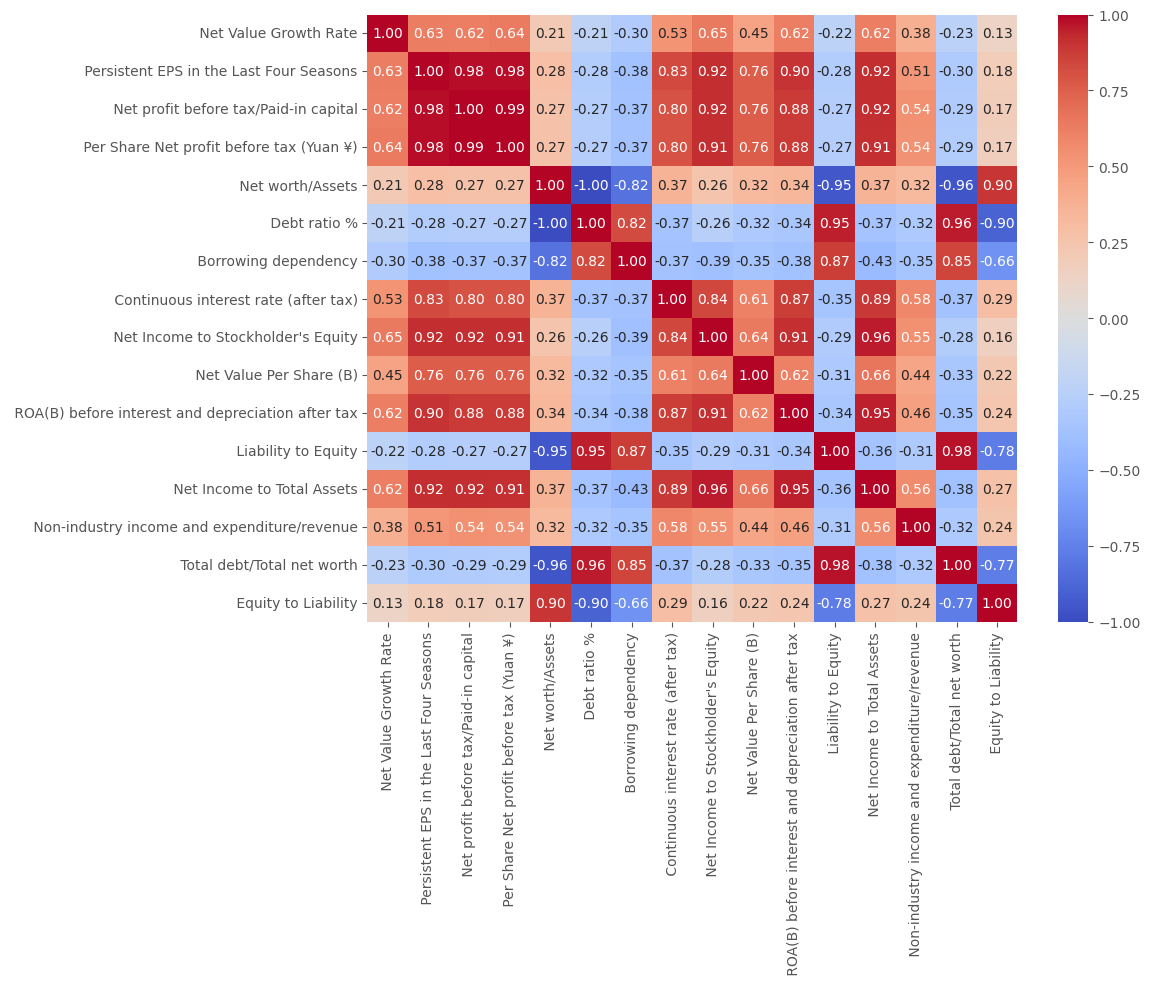

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(X_train[list_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.tight_layout(); plt.show()

## Removing some features based on correlation

In [ ]:
list_remove = [' ROA(A) before interest and % after tax',
               ' ROA(C) before interest and depreciation before interest',
               ' Per Share Net profit before tax (Yuan ¥)',
               ' Net profit before tax/Paid-in capital',
               ' Debt ratio %',
               ' Liability to Equity']
list_features = list(set(list_features) - set(list_remove))

X_train = X_train[list_features]
X_test = X_test[list_features]

The list of features that we use in the model:

In [ ]:
list_features

[" Net Income to Stockholder's Equity",
 ' Net Value Growth Rate',
 ' Net Value Per Share (B)',
 ' Total debt/Total net worth',
 ' ROA(B) before interest and depreciation after tax',
 ' Non-industry income and expenditure/revenue',
 ' Persistent EPS in the Last Four Seasons',
 ' Continuous interest rate (after tax)',
 ' Net Income to Total Assets',
 ' Borrowing dependency',
 ' Equity to Liability',
 ' Net worth/Assets']

## Final Data used to train subsequent models:

In [ ]:
print(X_train.shape)
print("-"*30)
print(y_train.value_counts())
print("-"*30)
X_train.head()

(4665, 12)
------------------------------
Bankrupt?
0    4241
1     424
Name: count, dtype: int64
------------------------------


Net Income to Stockholder's Equity  Net Value Growth Rate  \
0                            0.180257               0.297161   
1                            0.517794               0.407510   
2                            0.389429               0.411783   
3                            0.447744               0.415591   
4                            0.523769               0.473832   

   Net Value Per Share (B)  Total debt/Total net worth  \
0                 0.371947                    0.190705   
1                 0.455534                    0.074645   
2                 0.377672                    0.094336   
3                 0.422710                    0.697847   
4                 0.302481                    0.937556   

   ROA(B) before interest and depreciation after tax  \
0                                           0.168059   
1                                           0.490895   
2                                           0.549165   
3                                           0.381855   
4                                           0.620716   

   Non-industry income and expenditure/revenue  \
0                                     0.000000   
1                                     0.297768   
2                                     0.624749   
3                                     0.413114   
4                                     0.172893   

   Persistent EPS in the Last Four Seasons  \
0                                 0.252679   
1                                 0.494643   
2                                 0.377679   
3                                 0.439286   
4                                 0.457143   

   Continuous interest rate (after tax)  Net Income to Total Assets  \
0                              0.000000                    0.153212   
1                              0.870279                    0.578842   
2                              0.388600                    0.399584   
3                              0.573337                    0.421528   
4                              0.501936                    0.454564   

   Borrowing dependency  Equity to Liability  Net worth/Assets  
0              0.491304             0.451889          0.690682  
1              0.362189             0.952182          0.854707  
2              0.362189             0.786634          0.822268  
3              0.802021             0.197831          0.346069  
4              1.000000             0.172662          0.267598

# METHODS WE TRIED


Logistic Regression

Cross-Validation f1 scores : [0.761 0.727 0.772 0.766]
Mean Cross-Validation f1 score: 0.7564052648538288
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1060
           1       0.45      0.55      0.49        31

    accuracy                           0.97      1091
   macro avg       0.72      0.76      0.74      1091
weighted avg       0.97      0.97      0.97      1091

------------------------------------------------------------


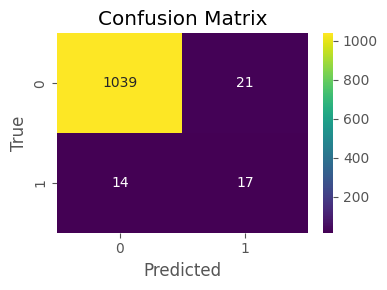

------------------------------------------------------------
Overall Accuracy: 96.78999999999999%


In [ ]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
y_predicted = model_1.predict(X_test)

# 7 fold cross validation

stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_1, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')

print("Cross-Validation f1 scores :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
logistic_mean_f1=np.mean(cv_scores)
print("Classification Report:")
figsize = (4,3)
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)

plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)

logistic_test_f1 = classification_report(y_test,y_predicted, output_dict=True)["macro avg"]["f1-score"]
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
logistic_test_a=accuracy

KNN Classifier

Cross-Validation f1 scores : [0.821 0.81  0.834 0.835]
Mean Cross-Validation f1 score: 0.8250561819918597
Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1060
           1       0.31      0.52      0.39        31

    accuracy                           0.95      1091
   macro avg       0.65      0.74      0.68      1091
weighted avg       0.97      0.95      0.96      1091


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1060
           1       0.31      0.52      0.39        31

    accuracy                           0.95      1091
   macro avg       0.65      0.74      0.68      1091
weighted avg       0.97      0.95      0.96      1091

------------------------------------------------------------


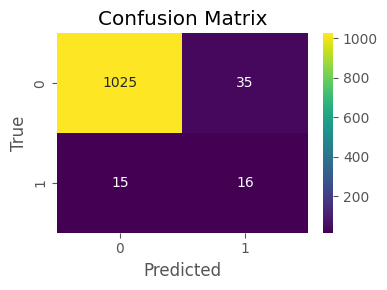

------------------------------------------------------------
Overall Accuracy: 95.42%


In [ ]:
model_2 = KNeighborsClassifier()
model_2.fit(X_train, y_train)
y_predicted = model_2.predict(X_test)

# 7 fold cross validation
cv_scores = cross_val_score(model_2, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
print("Cross-Validation f1 scores :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
knn_mean_f1=np.mean(cv_scores)
print("Classification Report:")
print("")
print(classification_report(y_test,y_predicted))
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)

knn_test_f1 = classification_report(y_test,y_predicted, output_dict=True)["macro avg"]["f1-score"]
plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
knn_test_a=accuracy

Decision Tree Classifier

Cross-Validation f1 score : [0.768 0.791 0.82  0.827]
Mean Cross-Validation f1 score: 0.8012108131067919
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1060
           1       0.22      0.45      0.29        31

    accuracy                           0.94      1091
   macro avg       0.60      0.70      0.63      1091
weighted avg       0.96      0.94      0.95      1091


              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1060
           1       0.22      0.45      0.29        31

    accuracy                           0.94      1091
   macro avg       0.60      0.70      0.63      1091
weighted avg       0.96      0.94      0.95      1091

------------------------------------------------------------


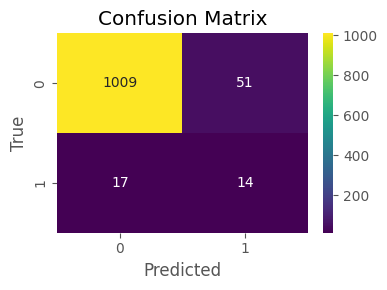

------------------------------------------------------------
Overall Accuracy: 93.77%


In [ ]:
model_3 = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
model_3.fit(X_train, y_train)
y_predicted = model_3.predict(X_test)

# 7 fold cross validation
cv_scores = cross_val_score(model_3, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
print("Cross-Validation f1 score :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
dt_mean_f1=np.mean(cv_scores)

print("Classification Report:")
print("")
print(classification_report(y_test,y_predicted))
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)

dt_test_f1 = classification_report(y_test,y_predicted, output_dict=True)["macro avg"]["f1-score"]
plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
dt_test_a=accuracy

XGBoost with Cross Validation

Cross-Validation f1 score : [0.839 0.867 0.883 0.859]
Mean Cross-Validation f1 score: 0.8617101198329435

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1060
           1       0.39      0.42      0.41        31

    accuracy                           0.97      1091
   macro avg       0.69      0.70      0.69      1091
weighted avg       0.97      0.97      0.97      1091


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1060
           1       0.39      0.42      0.41        31

    accuracy                           0.97      1091
   macro avg       0.69      0.70      0.69      1091
weighted avg       0.97      0.97      0.97      1091

------------------------------------------------------------


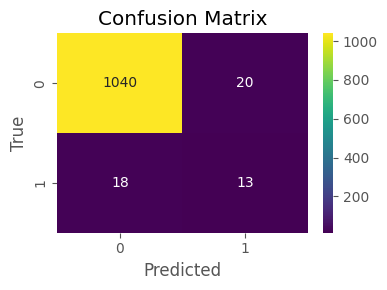

------------------------------------------------------------
Overall Accuracy: 96.52%


In [ ]:
model_4 = XGBClassifier()

# 7 fold cross validation
cv_scores = cross_val_score(model_4, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
print("Cross-Validation f1 score :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
xgb_mean_f1=np.mean(cv_scores)
model_4.fit(X_train, y_train)
y_predicted = model_4.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_predicted))
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)

xgb_test_f1 = classification_report(y_test,y_predicted, output_dict=True)["macro avg"]["f1-score"]
plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
xgb_test_a=accuracy

LGBM with cross validation\
(Light Gradient Boosting Machine Classifier)

Cross-Validation f1 scores : [0.843 0.857 0.881 0.861]
Mean Cross-Validation f1 score: 0.8604878183513968

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1060
           1       0.39      0.39      0.39        31

    accuracy                           0.97      1091
   macro avg       0.68      0.68      0.68      1091
weighted avg       0.97      0.97      0.97      1091


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1060
           1       0.39      0.39      0.39        31

    accuracy                           0.97      1091
   macro avg       0.68      0.68      0.68      1091
weighted avg       0.97      0.97      0.97      1091

------------------------------------------------------------


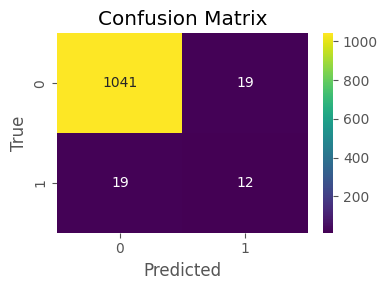

------------------------------------------------------------
Overall Accuracy: 96.52%


In [ ]:
positive_class_count = sum(y_train == 1)
negative_class_count = sum(y_train == 0)
scale_pos_weight = negative_class_count / positive_class_count


model_5 = LGBMClassifier(boosting_type='gbdt', force_col_wise=True, verbosity=-1)
"""
model_5 = LGBMClassifier(
    boosting_type='gbdt',
    force_col_wise=True,
    verbosity=-1,
    scale_pos_weight=scale_pos_weight  # Adjusting for class imbalance
)
"""

# 7 fold cross validation
cv_scores = cross_val_score(model_5, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
print("Cross-Validation f1 scores :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
lgbm_mean_f1=np.mean(cv_scores)
model_5.fit(X_train, y_train)
y_predicted = model_5.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_predicted))
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)
lgbm_test_f1 = classification_report(y_test,y_predicted, output_dict=True)["macro avg"]["f1-score"]
plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
lgbm_test_a=accuracy

Random forest

Cross-Validation f1 score : [0.826 0.853 0.848 0.836]
Mean Cross-Validation f1 score: 0.8409323866838677
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4241
           1       1.00      1.00      1.00       424

    accuracy                           1.00      4665
   macro avg       1.00      1.00      1.00      4665
weighted avg       1.00      1.00      1.00      4665

{'0': {'precision': 0.9820754716981132, 'recall': 0.9830028328611898, 'f1-score': 0.9825389334591789, 'support': 1059.0}, '1': {'precision': 0.41935483870967744, 'recall': 0.40625, 'f1-score': 0.4126984126984127, 'support': 32.0}, 'accuracy': 0.9660861594867094, 'macro avg': {'precision': 0.7007151552038953, 'recall': 0.6946264164305949, 'f1-score': 0.6976186730787958, 'support': 1091.0}, 'weighted avg': {'precision': 0.9655703752218254, 'recall': 0.9660861594867094, 'f1-score': 0.9658250043442892, 'support': 1091.0}}
--------------------------------------------

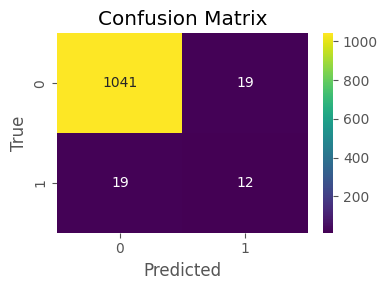

------------------------------------------------------------
Overall Accuracy: 96.52%


In [ ]:
random_forest = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200)
cv_scores = cross_val_score(random_forest, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
print("Cross-Validation f1 score :", cv_scores.round(3))
print("Mean Cross-Validation f1 score:", np.mean(cv_scores))
rf_mean_f1=np.mean(cv_scores)
random_forest.fit(X_train,y_train)
rf_train_preds = random_forest.predict(X_train)

rf_train_results = classification_report(rf_train_preds,y_train)
print(rf_train_results)

rf_test_preds = random_forest.predict(X_test)

rf_test_over_results = classification_report(rf_test_preds,y_test, output_dict=True)
print(rf_test_over_results)

print("-"*60)
rf_test_f1 = rf_test_over_results["macro avg"]["f1-score"]

#print("Macro F1-score:", macro_f1)
plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")
rf_test_a=accuracy

Neural Network\
(didn't expect this to work anyways, but here is the proof:)

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2368 - recall: 0.2852 - val_loss: 0.1076 - val_recall: 0.7097
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1528 - recall: 0.5531 - val_loss: 0.0981 - val_recall: 0.7097
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1539 - recall: 0.5647 - val_loss: 0.0834 - val_recall: 0.5806
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1510 - recall: 0.6074 - val_loss: 0.0931 - val_recall: 0.5484
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1517 - recall: 0.5763 - val_loss: 0.0887 - val_recall: 0.5806
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1656 - recall: 0.5326 - val_loss: 0.1006 - val_recall: 0.6452
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1354 - recall: 0.6727 - val_loss: 0.1032 - val_recall: 0.5806
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1459 - recall: 0.5018 - val_loss: 0.0969 - val_recall: 0.5806
Epoch 

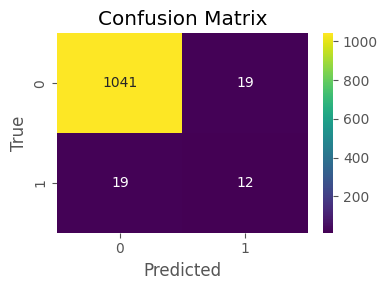

------------------------------------------------------------
Overall Accuracy: 96.52%


In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(640, activation='relu'),
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall'])
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = (model.predict(X_test) > 0.5).astype(int)
print("-"*100)
print(classification_report(y_test, y_predicted))
print("")
print(classification_report(y_test,y_predicted))
print("-"*60)

plt.figure(figsize=figsize)
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("-"*60)
accuracy = round(accuracy_score(y_test, y_predicted),4)*100
print(f"Overall Accuracy: {accuracy}%")

# Comparision of different models and selection

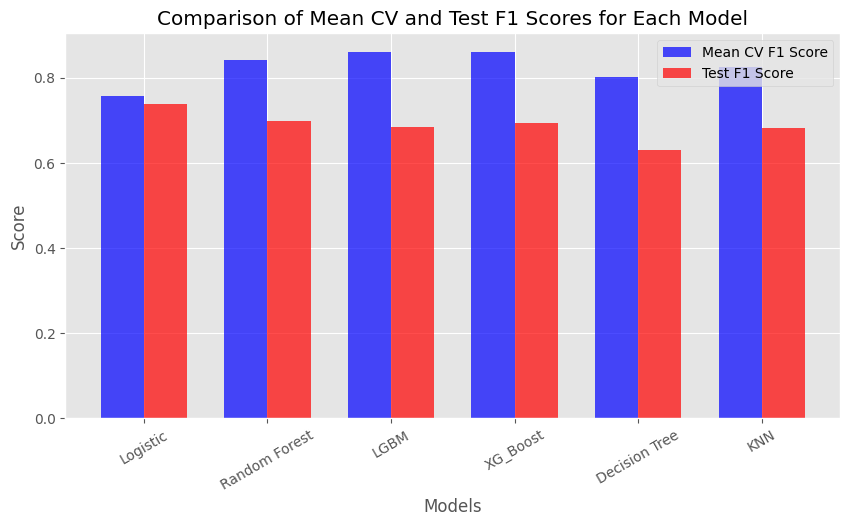

In [ ]:
models= ['Logistic', 'Random Forest', 'LGBM', 'XG_Boost', 'Decision Tree','KNN']
mean_f1_scores= [logistic_mean_f1,rf_mean_f1,lgbm_mean_f1,xgb_mean_f1,dt_mean_f1,knn_mean_f1]
test_f1_scores = [logistic_test_f1,rf_test_f1,lgbm_test_f1,xgb_test_f1,dt_test_f1,knn_test_f1]
accuracies=[logistic_test_a,rf_test_a,lgbm_test_a,xgb_test_a,dt_test_a,knn_test_a]
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, mean_f1_scores, width, label="Mean CV F1 Score", color='b', alpha=0.7)
ax.bar(x + width/2, test_f1_scores, width, label="Test F1 Score", color='r', alpha=0.7)

ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of Mean CV and Test F1 Scores for Each Model")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30)
ax.legend()

plt.show()

# BEST MODEL SELECTED: LOGISTIC REGRESSION
this was selected on basis of cross validation mean f1 score and accuracy, as well as f1, precision, recall on the test set

## We now perform gridsearch to tune the model further and optimize it for the task
parameters tuned:
- C: inverse regularisation strength $\left(C = 1/λ\right)$
- penalty: type of regularisation (ridge, lasso, etc.)
- solver: loss function optimization algorithm
- class_weight: adjusting for the severe class imbalance
- max_iter: maximum iterations for training the model

Fitting 4 folds for each of 252 candidates, totalling 1008 fits
Best F1 Score: 0.9331184106672781
Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1060
           1       0.50      0.58      0.54        31

    accuracy                           0.97      1091
   macro avg       0.74      0.78      0.76      1091
weighted avg       0.97      0.97      0.97      1091



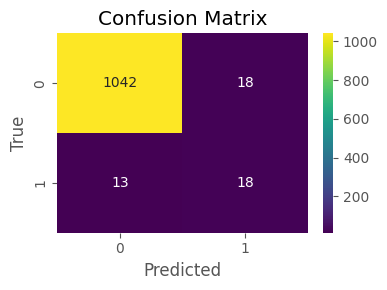

------------------------------------------------------------
Overall Accuracy: 97.16%


['sklearn_model.h5']

In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # c = 1/lambda
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [100, 500, 1000]
}

model = LogisticRegression()
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best F1 Score: {grid_search.best_score_}")
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_predicted = best_model.predict(X_test)

print("-" * 60)
print("Classification Report:")
print(classification_report(y_test, y_predicted))

plt.figure(figsize=(4, 3))
conf_matrix = confusion_matrix(y_test, y_predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("-" * 60)
accuracy = round(accuracy_score(y_test, y_predicted), 4) * 100
print(f"Overall Accuracy: {accuracy}%")


import joblib

# Save the model
joblib.dump(best_model, 'sklearn_model.h5')


## Saved the model as "sklearn_model.h5"
